In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.layers import Embedding, Flatten

from sklearn.model_selection import train_test_split #
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import normalize, OneHotEncoder
import scipy
import itertools
from sklearn.feature_extraction.text import CountVectorizer
import unicodedata, re, string
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer


## Nacitanie

In [ ]:
dataset = pd.read_csv('../Data/final_2000_balanced.csv')

## Rozdelenie dat na sady

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_text'], dataset['author_id'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
print(X_train[:10])

1751    set flame grand truth vouchsafed feel importan...
1362    jules gave cautious glance shoulder towards ho...
93      truly calabrian horses snorted pranced manes b...
45      oh says 'll miss said patty 's like alone 's s...
183     'this friend durandarte flower mirror true lov...
1163    space somewhat impressive tableau humorous wel...
1788    sunday th december  way climbed eastern shin h...
498     came however reverse fine day spring mountain ...
1567    morning buoys set lake end measured course cou...
121     holding breath waited motion stable began clim...
Name: processed_text, dtype: object


## One hot encoding

In [ ]:
one_hot_encoder = OneHotEncoder()

y_train = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.transform(y_valid.to_numpy().reshape(-1, 1)).toarray()
y_test = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1)).toarray()

In [ ]:
print(y_valid)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


# CountVectorizer

In [ ]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()
X_valid = vectorizer.transform(X_valid).toarray()


In [ ]:
y_train.shape

(1314, 44)

## Model 1

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               15074432  
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 44)                2860      
                                                                 
Total params: 15085548 (57.55 MB)
Trainable params: 15085548 (57.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size = 64, callbacks=[model_checkpoint_callback])

Epoch 1/10
21/21 [==============================] - 3s 87ms/step - loss: 4.2701 - accuracy: 0.0304 - val_loss: 3.6249 - val_accuracy: 0.0959
Epoch 2/10
21/21 [==============================] - 1s 64ms/step - loss: 3.7342 - accuracy: 0.0540 - val_loss: 3.6198 - val_accuracy: 0.1096
Epoch 3/10
21/21 [==============================] - 1s 59ms/step - loss: 3.6786 - accuracy: 0.0670 - val_loss: 3.4422 - val_accuracy: 0.1644
Epoch 4/10
21/21 [==============================] - 2s 99ms/step - loss: 3.5956 - accuracy: 0.0814 - val_loss: 3.3732 - val_accuracy: 0.1507
Epoch 5/10
21/21 [==============================] - 1s 66ms/step - loss: 3.5198 - accuracy: 0.1088 - val_loss: 3.3543 - val_accuracy: 0.1986
Epoch 6/10
21/21 [==============================] - 1s 62ms/step - loss: 3.4351 - accuracy: 0.1104 - val_loss: 3.3487 - val_accuracy: 0.1849
Epoch 7/10
21/21 [==============================] - 1s 62ms/step - loss: 3.4382 - accuracy: 0.1134 - val_loss: 3.2899 - val_accuracy: 0.1918
Epoch 8/10
21

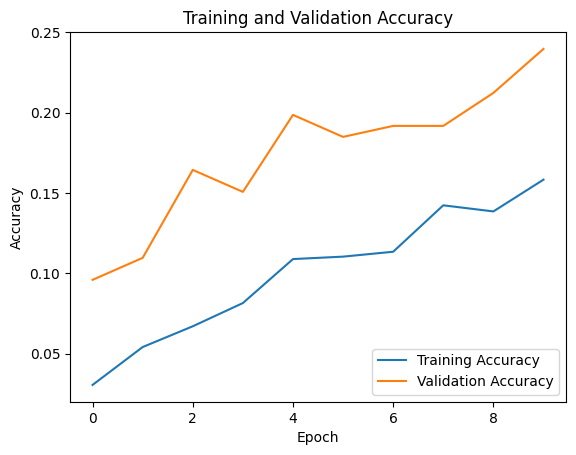

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_indices = np.argmax(y_test, axis=1)

test_f1 = f1_score(y_test_indices, y_pred, average='macro')
test_precision = precision_score(y_test_indices, y_pred, average='macro')
test_recall = recall_score(y_test_indices, y_pred, average='macro')

print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')
print(f'Test F1 Score: {test_f1}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')

12/12 [==============================] - 0s 11ms/step
(365,)
(365, 44)
(365,)
(365, 44)
Test loss: 3.11482310295105
Test accuracy: 0.22739726305007935
Test F1 Score: 0.20832423063074598
Test Precision: 0.1974660849341114
Test Recall: 0.26304440508985966


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model 2

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size = 128, callbacks=[model_checkpoint_callback])

Epoch 1/10
11/11 [==============================] - 5s 290ms/step - loss: 4.1032 - accuracy: 0.0609 - val_loss: 3.3325 - val_accuracy: 0.1849
Epoch 2/10
11/11 [==============================] - 3s 244ms/step - loss: 3.0632 - accuracy: 0.2329 - val_loss: 2.4434 - val_accuracy: 0.4658
Epoch 3/10
11/11 [==============================] - 6s 549ms/step - loss: 2.1273 - accuracy: 0.4977 - val_loss: 1.4025 - val_accuracy: 0.7671
Epoch 4/10
11/11 [==============================] - 3s 267ms/step - loss: 1.2716 - accuracy: 0.7207 - val_loss: 0.9972 - val_accuracy: 0.8630
Epoch 5/10
11/11 [==============================] - 3s 263ms/step - loss: 0.8071 - accuracy: 0.8394 - val_loss: 0.7057 - val_accuracy: 0.8836
Epoch 6/10
11/11 [==============================] - 5s 489ms/step - loss: 0.5421 - accuracy: 0.9003 - val_loss: 0.5128 - val_accuracy: 0.9521
Epoch 7/10
11/11 [==============================] - 3s 269ms/step - loss: 0.3708 - accuracy: 0.9437 - val_loss: 0.4496 - val_accuracy: 0.9452
Epoch 

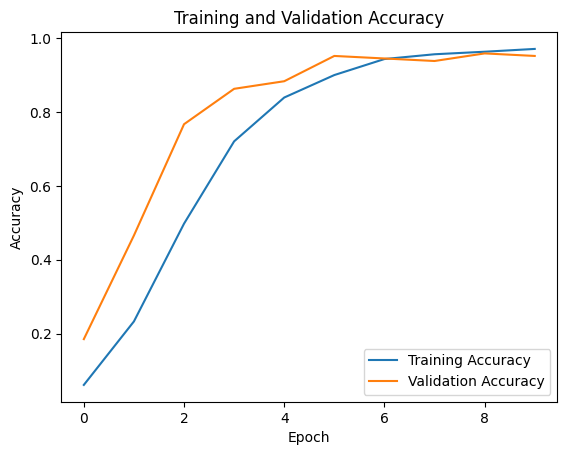

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_indices = np.argmax(y_test, axis=1)

test_f1 = f1_score(y_test_indices, y_pred, average='macro')
test_precision = precision_score(y_test_indices, y_pred, average='macro')
test_recall = recall_score(y_test_indices, y_pred, average='macro')

print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')
print(f'Test F1 Score: {test_f1}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')

12/12 [==============================] - 0s 12ms/step
Test loss: 0.40440648794174194
Test accuracy: 0.9342465996742249
Test F1 Score: 0.9408217578045892
Test Precision: 0.9464867834186016
Test Recall: 0.9452938475665748


# TextVectorization

## Model 3


In [ ]:
embedding_dim = 256
vocab_size = 60000
sequence_length = 6000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

In [ ]:
model = tf.keras.Sequential([
    vect_layer,
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=sequence_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_11 (Tex  (None, 6000)              0         
 tVectorization)                                                 
                                                                 
 embedding_11 (Embedding)    (None, 6000, 256)         17920000  
                                                                 
 global_average_pooling1d_1  (None, 256)               0         
 1 (GlobalAveragePooling1D)                                      
                                                                 
 dense_53 (Dense)            (None, 128)               32896     
                                                                 
 dropout_42 (Dropout)        (None, 128)               0         
                                                                 
 dense_54 (Dense)            (None, 64)              

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size = 8, callbacks=[model_checkpoint_callback])

Epoch 1/10
165/165 [==============================] - 24s 135ms/step - loss: 3.7051 - accuracy: 0.0342 - val_loss: 3.5902 - val_accuracy: 0.0411
Epoch 2/10
165/165 [==============================] - 22s 131ms/step - loss: 3.4363 - accuracy: 0.0571 - val_loss: 3.3723 - val_accuracy: 0.0753
Epoch 3/10
165/165 [==============================] - 20s 119ms/step - loss: 3.1536 - accuracy: 0.1065 - val_loss: 3.0205 - val_accuracy: 0.1781
Epoch 4/10
165/165 [==============================] - 19s 117ms/step - loss: 2.7487 - accuracy: 0.1918 - val_loss: 2.5979 - val_accuracy: 0.2877
Epoch 5/10
165/165 [==============================] - 19s 114ms/step - loss: 2.2926 - accuracy: 0.2915 - val_loss: 2.1272 - val_accuracy: 0.3973
Epoch 6/10
165/165 [==============================] - 19s 117ms/step - loss: 1.9622 - accuracy: 0.3623 - val_loss: 1.7218 - val_accuracy: 0.5342
Epoch 7/10
165/165 [==============================] - 17s 104ms/step - loss: 1.5476 - accuracy: 0.5030 - val_loss: 1.4692 - val_ac

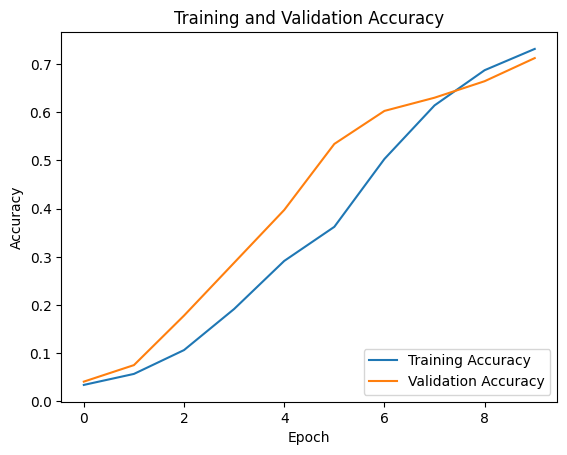

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

12/12 [==============================] - 1s 36ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted')
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.726027397260274
F1 Score: 0.7290472539782721
Precision: 0.7861900673532246
Recall: 0.726027397260274


## Model 4

In [ ]:
embedding_dim = 128
vocab_size = 10000
sequence_length = 10000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

In [ ]:
model = tf.keras.Sequential([
    vect_layer,
    tf.keras.layers.Embedding(vocab_size, 128, input_length=sequence_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

model.summary()

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_13 (Tex  (None, 10000)             0         
 tVectorization)                                                 
                                                                 
 embedding_13 (Embedding)    (None, 10000, 128)        1280000   
                                                                 
 global_average_pooling1d_1  (None, 128)               0         
 3 (GlobalAveragePooling1D)                                      
                                                                 
 dense_61 (Dense)            (None, 512)               66048     
                                                                 
 dropout_48 (Dropout)        (None, 512)               0         
                                                                 
 dense_62 (Dense)            (None, 256)             

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size = 8, callbacks=[model_checkpoint_callback])

Epoch 1/10
165/165 [==============================] - 24s 133ms/step - loss: 3.7062 - accuracy: 0.0312 - val_loss: 3.6045 - val_accuracy: 0.0274
Epoch 2/10
165/165 [==============================] - 20s 121ms/step - loss: 3.4502 - accuracy: 0.0578 - val_loss: 3.4543 - val_accuracy: 0.0548
Epoch 3/10
165/165 [==============================] - 19s 116ms/step - loss: 3.2823 - accuracy: 0.0578 - val_loss: 3.2229 - val_accuracy: 0.1027
Epoch 4/10
165/165 [==============================] - 17s 104ms/step - loss: 3.0693 - accuracy: 0.0890 - val_loss: 2.8929 - val_accuracy: 0.1301
Epoch 5/10
165/165 [==============================] - 17s 100ms/step - loss: 2.8179 - accuracy: 0.1294 - val_loss: 2.7791 - val_accuracy: 0.1507
Epoch 6/10
165/165 [==============================] - 15s 91ms/step - loss: 2.6506 - accuracy: 0.1621 - val_loss: 2.8165 - val_accuracy: 0.1438
Epoch 7/10
165/165 [==============================] - 14s 84ms/step - loss: 2.4583 - accuracy: 0.1857 - val_loss: 2.7723 - val_accu

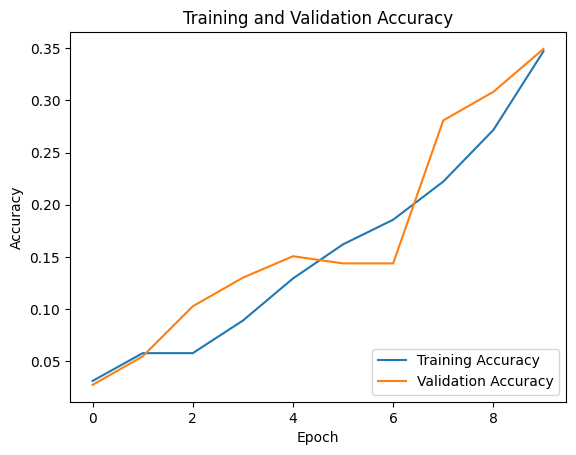

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

12/12 [==============================] - 1s 36ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.3643835616438356
F1 Score: 0.3132948249782084
Precision: 0.35200455235720834
Recall: 0.3643835616438356


## Model 4 - vacsi vocab_size

In [ ]:
embedding_dim = 256
vocab_size = 60000
sequence_length = 6000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

In [ ]:
model = tf.keras.Sequential([
    vect_layer,
    tf.keras.layers.Embedding(vocab_size, 128, input_length=sequence_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

model.summary()

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_12 (Tex  (None, 6000)              0         
 tVectorization)                                                 
                                                                 
 embedding_12 (Embedding)    (None, 6000, 128)         7680000   
                                                                 
 global_average_pooling1d_1  (None, 128)               0         
 2 (GlobalAveragePooling1D)                                      
                                                                 
 dense_56 (Dense)            (None, 512)               66048     
                                                                 
 dropout_44 (Dropout)        (None, 512)               0         
                                                                 
 dense_57 (Dense)            (None, 256)             

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size = 8, callbacks=[model_checkpoint_callback])

Epoch 1/10
165/165 [==============================] - 24s 132ms/step - loss: 3.6877 - accuracy: 0.0426 - val_loss: 3.5664 - val_accuracy: 0.0205
Epoch 2/10
165/165 [==============================] - 21s 126ms/step - loss: 3.3548 - accuracy: 0.0510 - val_loss: 3.2751 - val_accuracy: 0.1027
Epoch 3/10
165/165 [==============================] - 20s 118ms/step - loss: 3.0718 - accuracy: 0.0807 - val_loss: 3.1323 - val_accuracy: 0.0685
Epoch 4/10
165/165 [==============================] - 19s 116ms/step - loss: 2.7990 - accuracy: 0.1104 - val_loss: 2.8580 - val_accuracy: 0.1575
Epoch 5/10
165/165 [==============================] - 18s 107ms/step - loss: 2.6289 - accuracy: 0.1332 - val_loss: 2.7271 - val_accuracy: 0.1370
Epoch 6/10
165/165 [==============================] - 19s 113ms/step - loss: 2.5120 - accuracy: 0.1522 - val_loss: 2.6223 - val_accuracy: 0.1575
Epoch 7/10
165/165 [==============================] - 18s 109ms/step - loss: 2.3169 - accuracy: 0.1979 - val_loss: 2.4047 - val_ac

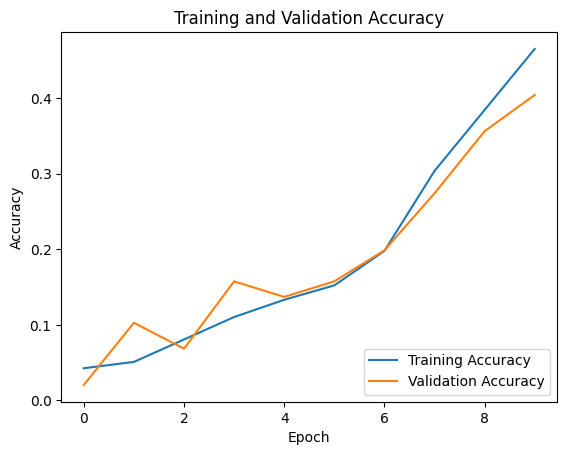

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

12/12 [==============================] - 1s 38ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.410958904109589
F1 Score: 0.37037976881384294
Precision: 0.4061913530406681
Recall: 0.410958904109589
